### Import libraries and get data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pmd

from sklearn.metrics import mean_squared_error, mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

## Preprocessing data

In [11]:
# Load the dataset
df = pd.read_csv("./USDT.csv")

# Drop the unnecessary columns.
df.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1, inplace=True)

# Convert the "Date" column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%b-%y')
                                    
# Sort the DataFrame by date
df = df.sort_values('Date')

# Set Date index
df.set_index('Date', inplace=True)

df

,Price
Date,
2017-12-01,1.0100
2017-12-02,0.9959
2017-12-03,0.9977
2017-12-04,1.0000
2017-12-05,1.0000
...,...
2023-03-28,1.0001
2023-03-29,0.9999
2023-03-30,1.0000


### Split the data into training (70%), test (20%) and validate (10%) sets

In [12]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)
print("Validate shape:", val_data.shape)

Train shape: (1362, 1)
Test shape: (389, 1)
Validate shape: (196, 1)


## ARIMA Model

### 3. Perfom ARIMA Model 

In [5]:
!pip install pmdarima


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

### 3.1 Build the best ARIMA Model using p,d,q from auto_arima

In [15]:
arima_model = pmd.auto_arima(y_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=False,
                         d=None, D=0, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

C:\Users\PHUTRAN\AppData\Local\Programs\Python\Python311\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-11684.760, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3868.101, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=1.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-11723.739, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.32 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-11721.681, Time=0.21 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-11723.605, Time=0.14 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=inf, Time=0.58 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-11721.615, Time=0.15 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-11756.317, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-11102.504, Time=1.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-11738.216, Time=0.38 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=

### 3.2 Evaluate on Test data

In [19]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred_test = arima_model.predict(n_periods=len(y_test))

print("Price predict on test data:", y_pred_test)

Price predict on test data: [1.00033935 1.00034279 1.00034079 1.00033895 1.00033726 1.00033571
 1.00033429 1.00033299 1.00033179 1.00033069 1.00032968 1.00032876
 1.00032791 1.00032713 1.00032642 1.00032576 1.00032516 1.0003246
 1.0003241  1.00032363 1.00032321 1.00032281 1.00032245 1.00032213
 1.00032182 1.00032154 1.00032129 1.00032106 1.00032084 1.00032064
 1.00032046 1.0003203  1.00032015 1.00032001 1.00031988 1.00031976
 1.00031965 1.00031955 1.00031946 1.00031938 1.0003193  1.00031923
 1.00031917 1.00031911 1.00031905 1.000319   1.00031896 1.00031892
 1.00031888 1.00031884 1.00031881 1.00031878 1.00031875 1.00031873
 1.00031871 1.00031868 1.00031866 1.00031865 1.00031863 1.00031862
 1.0003186  1.00031859 1.00031858 1.00031857 1.00031856 1.00031855
 1.00031854 1.00031853 1.00031853 1.00031852 1.00031851 1.00031851
 1.0003185  1.0003185  1.0003185  1.00031849 1.00031849 1.00031848
 1.00031848 1.00031848 1.00031848 1.00031847 1.00031847 1.00031847
 1.00031847 1.00031847 1.00031847 1

### 3.3 Evaluate on Validate data

In [20]:
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Price'])
y_pred_val =  arima_model.predict(n_periods=len(y_val))

print("Price predict on validate data:", y_pred_val)

Price predict on validate data: [1.00033935 1.00034279 1.00034079 1.00033895 1.00033726 1.00033571
 1.00033429 1.00033299 1.00033179 1.00033069 1.00032968 1.00032876
 1.00032791 1.00032713 1.00032642 1.00032576 1.00032516 1.0003246
 1.0003241  1.00032363 1.00032321 1.00032281 1.00032245 1.00032213
 1.00032182 1.00032154 1.00032129 1.00032106 1.00032084 1.00032064
 1.00032046 1.0003203  1.00032015 1.00032001 1.00031988 1.00031976
 1.00031965 1.00031955 1.00031946 1.00031938 1.0003193  1.00031923
 1.00031917 1.00031911 1.00031905 1.000319   1.00031896 1.00031892
 1.00031888 1.00031884 1.00031881 1.00031878 1.00031875 1.00031873
 1.00031871 1.00031868 1.00031866 1.00031865 1.00031863 1.00031862
 1.0003186  1.00031859 1.00031858 1.00031857 1.00031856 1.00031855
 1.00031854 1.00031853 1.00031853 1.00031852 1.00031851 1.00031851
 1.0003185  1.0003185  1.0003185  1.00031849 1.00031849 1.00031848
 1.00031848 1.00031848 1.00031848 1.00031847 1.00031847 1.00031847
 1.00031847 1.00031847 1.000318

### 3.4 Predict price for the next 30 days

In [51]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index = len(df)

date_range = pd.date_range(start=df.index[-1], periods=30, freq='D')

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = arima_model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[1.00033935 1.00034279 1.00034079 1.00033895 1.00033726 1.00033571
 1.00033429 1.00033299 1.00033179 1.00033069 1.00032968 1.00032876
 1.00032791 1.00032713 1.00032642 1.00032576 1.00032516 1.0003246
 1.0003241  1.00032363 1.00032321 1.00032281 1.00032245 1.00032213
 1.00032182 1.00032154 1.00032129 1.00032106 1.00032084 1.00032064]


### 4.  Evaluate accuracy validate, test data

In [52]:
# Calculate MAPE

def mean_absolute_percentage_error(predict, actual):
    return np.mean(np.abs(predict - actual)/np.abs(actual))

val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
test_mape= mean_absolute_percentage_error(y_pred_test, y_test)

print("Validation MAPE: ", val_mape)
print("Test MAPE: ", test_mape)

Validation MAPE:  0.0005248595746752178
Test MAPE:  0.0003716949877495106


In [53]:
# Calculate MAE

val_mae  = mean_absolute_error(y_pred_val, y_val)
test_mae = mean_absolute_error(y_pred_test, y_test)

print("Validation MAE: ", val_mae)
print("Test MAE: ", test_mae)

Validation MAE:  0.0005254824409899084
Test MAE:  0.00037158022607563926


In [54]:
# Calculate MSE

val_mse  = mean_squared_error(y_pred_val, y_val)
test_mse = mean_squared_error(y_pred_test, y_test)

print("Validation MSE: ", val_mae)
print("Test MSE: ", test_mae)

Validation MSE:  0.0005254824409899084
Test MSE:  0.00037158022607563926


In [55]:
# Calculate RMSE

valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))

print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 0.000990829526432764
Testing RMSE: 0.0005564536005732329


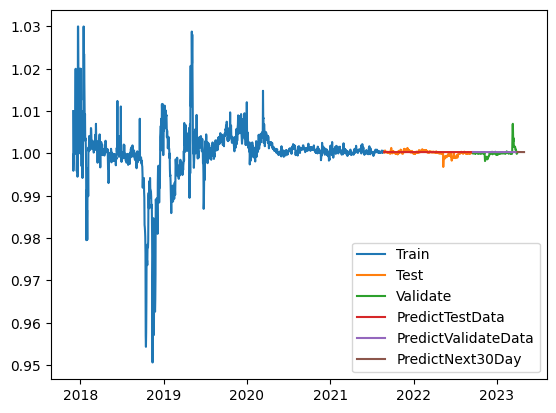

In [67]:
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(val_data.index, val_data['Price'])

plt.plot(test_data.index, y_pred_test)
plt.plot(val_data.index, y_pred_val)
plt.plot(date_range, y_next_30_days)

plt.legend(['Train', 'Test', 'Validate','PredictTestData', 'PredictValidateData','PredictNext30Day'])
plt.show()